In [2]:
#https://pastebin.com/F4g5dmnn

<h3>Importing Libraries</h3>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings

### Reading the file

In [5]:
train = pd.read_csv("https://pastebin.com/raw/F4g5dmnn",sep='\t', lineterminator='\n')
train['Transaction_Count']=train['Transaction Count\r']
train.drop('Transaction Count\r',axis=1,inplace=True)

In [6]:
train_original = train.copy()


In [7]:
train['Date']=pd.to_datetime(train.Date,format='%d/%m/%y %H:%M')
train_original['Date']=pd.to_datetime(train_original.Date,format='%d/%m/%y %H:%M')

In [8]:
# train['Date'] = train_original['Date'].dt.date

In [9]:
train['day of the week'] = train['Date'].dt.dayofweek

In [10]:
def applyer(row):
    if row.dayofweek==5 or row.dayofweek==6:
        return 1
    else:
        return 0
temp2 = train['Date'].apply(applyer)
train['weekend']=temp2

In [11]:
train.index=train['Date']
# df = train.drop('ID',1)
tc = train['Transaction_Count']

### Plotting the data for finding hypothesis

C:\Users\ALBIN\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


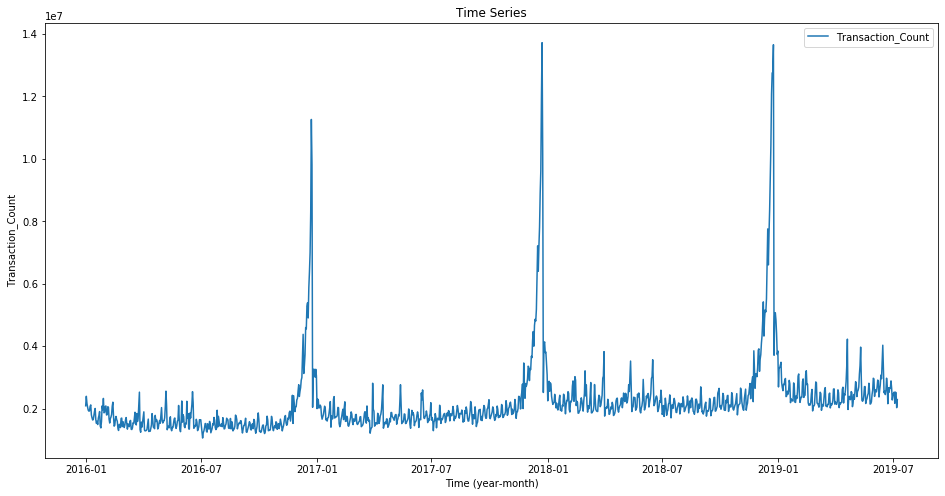

In [12]:
plt.figure(figsize=(16,8))
plt.plot(tc,label='Transaction_Count')
plt.title('Time Series')
plt.xlabel("Time (year-month)")
plt.ylabel("Transaction_Count")
plt.legend(loc="best")

In [13]:
#Its clear that the given data is having a seasonality
# Lets do some more exploratory analysis

In [14]:
# train['Date'] = pd.to_datetime(train['Date'])
# train_original['Date'] = pd.to_datetime(train_original['Date'])
for i in (train,train_original):
    i['year'] = i.Date.dt.year
    i['month'] = i.Date.dt.month
    i['day'] =i.Date.dt.day


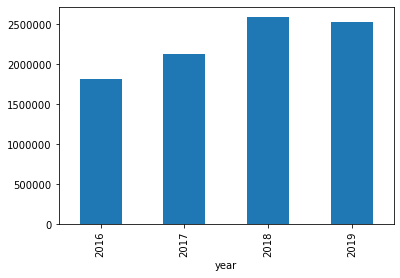

In [15]:
train.groupby('year')['Transaction_Count'].mean().plot.bar()

In [16]:
#There is a trend in data as it increases on time

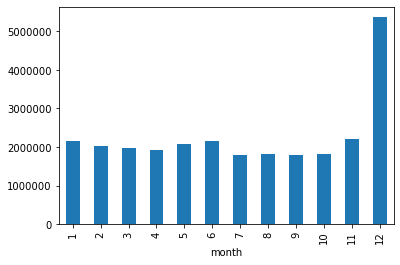

In [17]:
train.groupby('month')['Transaction_Count'].mean().plot.bar()

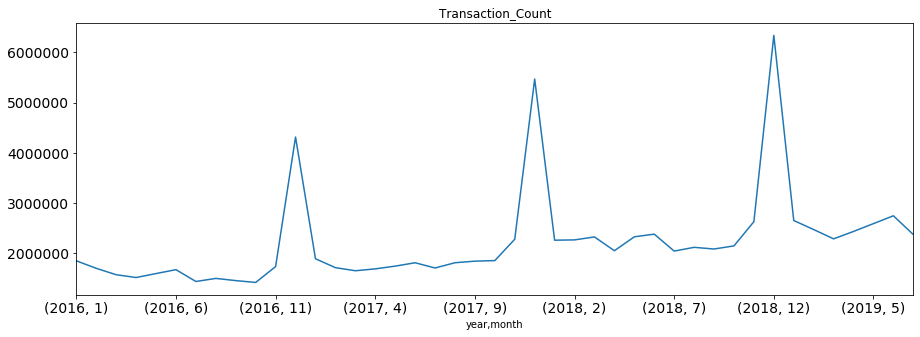

In [18]:
temp =train.groupby(['year','month'])['Transaction_Count'].mean()
temp.plot(figsize=(15,5),title='Transaction_Count',fontsize=14)

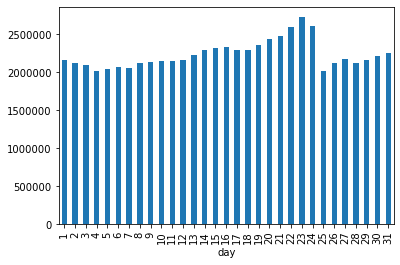

In [19]:
train.groupby('day')['Transaction_Count'].mean().plot.bar()

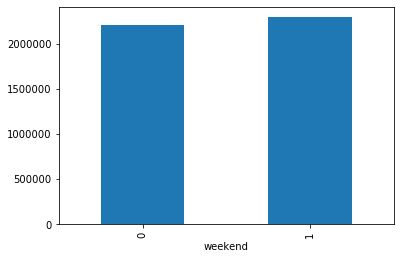

In [20]:
train.groupby('weekend')['Transaction_Count'].mean().plot.bar()

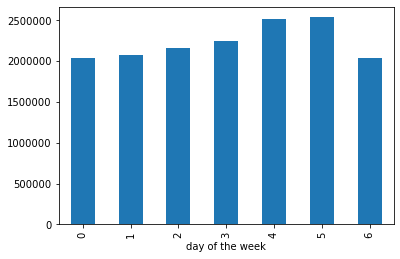

In [21]:
train.groupby('day of the week')['Transaction_Count'].mean().plot.bar()

In [22]:
daily=train.resample('D').mean()
weekly = train.resample('W').mean()
monthly = train.resample('M').mean()

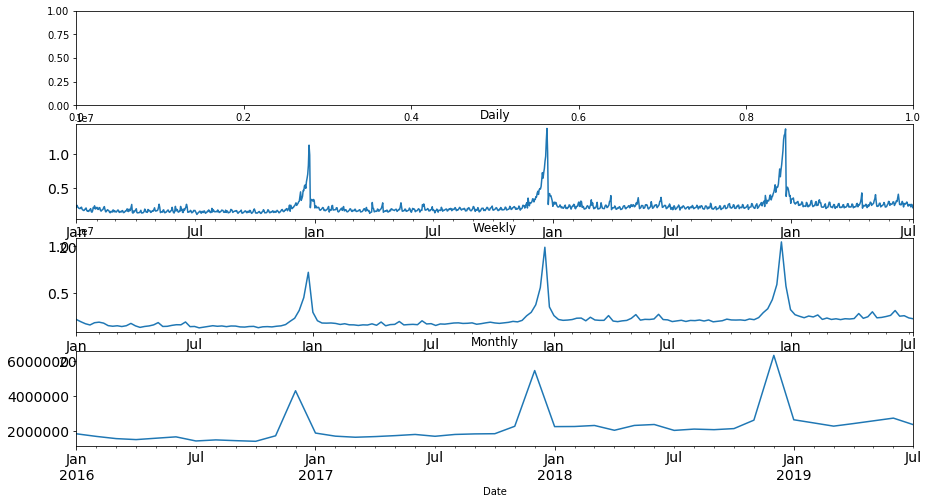

In [23]:
fig,axs = plt.subplots(4,1)
daily.Transaction_Count.plot(figsize=(15,8),title='Daily',fontsize=14,ax=axs[1])
weekly.Transaction_Count.plot(figsize=(15,8),title='Weekly',fontsize=14,ax=axs[2])
monthly.Transaction_Count.plot(figsize=(15,8),title='Monthly',fontsize=14,ax=axs[3])

In [24]:
# train.Timestamp=pd.to_datetime(train.Date,format="%d-%m-%Y %H:%M")
# train.index = train.Timestamp

In [25]:
train_2 = train.resample('M').mean()

In [26]:
Train = train_2.ix['2016-01-01':'2018-10-01']
valid = train_2.ix['2018-10-02':'2019-07-08']

C:\Users\ALBIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
C:\Users\ALBIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  


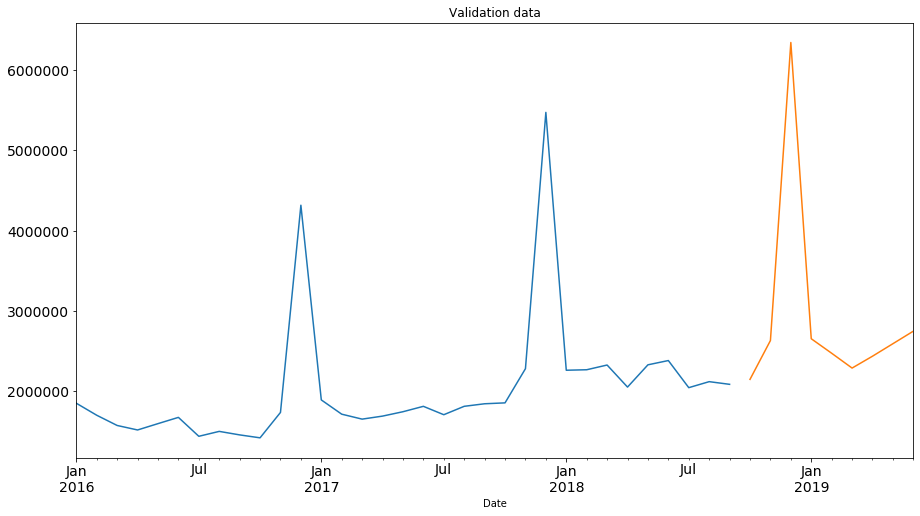

In [27]:
Train.Transaction_Count.plot(figsize=(15,8),title='Training data ',fontsize=14,label='train')
valid.Transaction_Count.plot(figsize=(15,8),title="Validation data",fontsize=14,label='valid')

Dicky Fuller results1: 
Test Statistic                   -5.502094
p-value                           0.000002
#lags used                       14.000000
Number of observations used    1270.000000
Critical Value (1%)              -3.435510
Critical Value (5%)              -2.863818
Critical Value (10%)             -2.567983
dtype: float64
Done


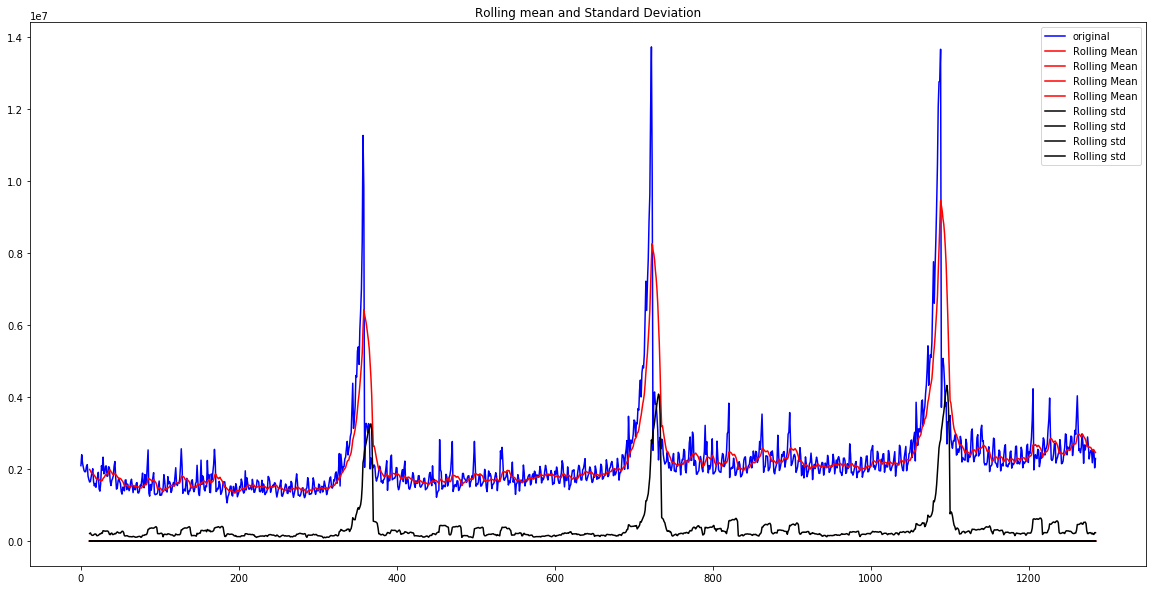

In [36]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    rolmean = train_original.rolling(12).mean()
    rolstd = train_original.rolling(12).std()
    orig = plt.plot(timeseries,color='blue',label='original')
    mean = plt.plot(rolmean,color='red',label='Rolling Mean')
    Std = plt.plot(rolstd,color='black',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling mean and Standard Deviation')
#     plt.show(block=False)
    print('Dicky Fuller results1: ')
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)
    print('Done')
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 20,10
test_stationarity(train_original['Transaction_Count'])

In [37]:
#As the test value is less than the critical value the time series is stationary 
#But we need to make it more stationary 

### Moving Average

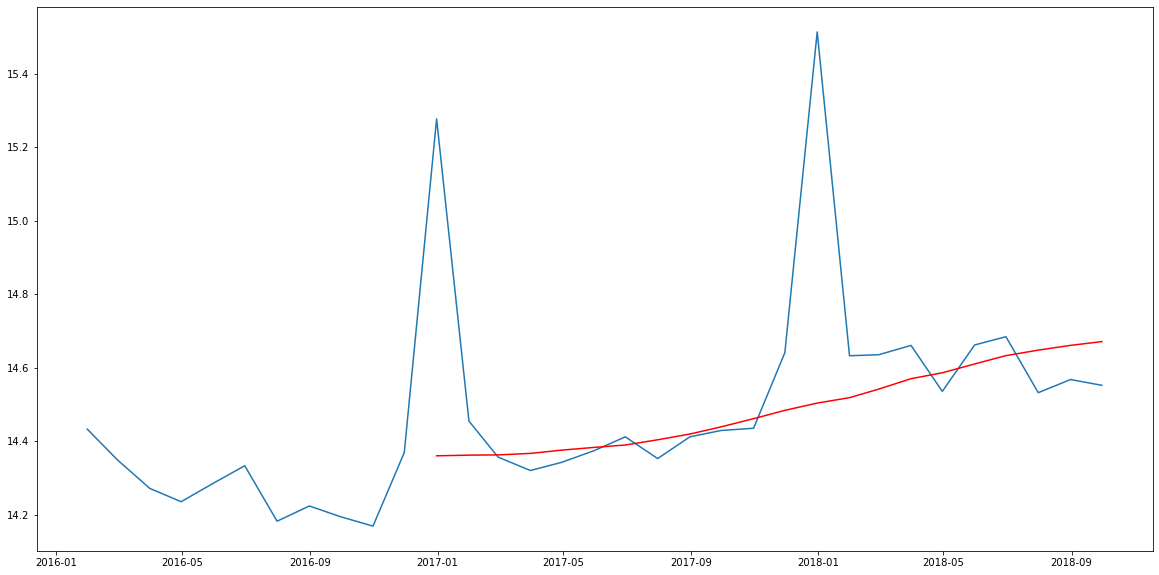

In [38]:
Train_log = np.log(Train['Transaction_Count'])
valid_log = np.log(valid['Transaction_Count'])
moving_avg = Train_log.rolling(12).mean()
plt.plot(Train_log)
plt.plot(moving_avg,color='red')
plt.show()

In [39]:
train_log_moving_avg_diff= Train_log - moving_avg
train_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(train_log_moving_avg_diff)

Dicky Fuller results1: 
Test Statistic                 -4.774613
p-value                         0.000061
#lags used                      0.000000
Number of observations used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64
Done


ValueError: view limit minimum -36836.8 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

Date
2016-01-31    14.432602
2016-02-29    14.348606
2016-03-31    14.271069
2016-04-30    14.234948
2016-05-31    14.285491
2016-06-30    14.332935
2016-07-31    14.181864
2016-08-31    14.223311
2016-09-30    14.193894
2016-10-31    14.168513
2016-11-30    14.368900
2016-12-31    15.277872
2017-01-31    14.454648
2017-02-28    14.356373
2017-03-31    14.319917
2017-04-30    14.342325
2017-05-31    14.373976
2017-06-30    14.411638
2017-07-31    14.352510
2017-08-31    14.411799
2017-09-30    14.429068
2017-10-31    14.435079
2017-11-30    14.641076
2017-12-31    15.514920
2018-01-31    14.632633
2018-02-28    14.635324
2018-03-31    14.660848
2018-04-30    14.535560
2018-05-31    14.661988
2018-06-30    14.684476
2018-07-31    14.532040
2018-08-31    14.567849
2018-09-30    14.552063
Freq: M, Name: Transaction_Count, dtype: float64


C:\Users\ALBIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


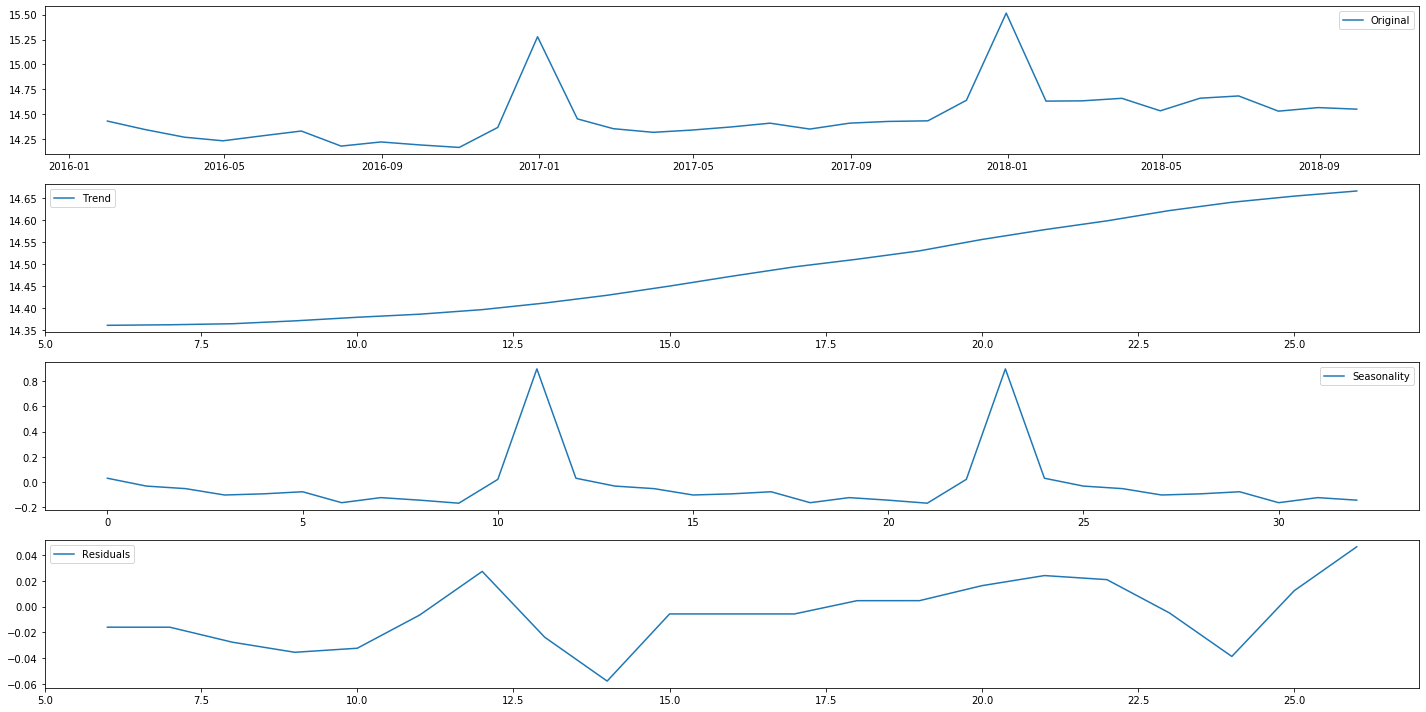

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
df = pd.DataFrame(Train_log.values)
decomposition = seasonal_decompose(df,freq=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log,label='Original')
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal,label="Seasonality")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [62]:
train_log_decompose = pd.DataFrame(residual)
# datetime_series = pd.to_datetime(Train_log.index,format='%m-%d-%Y')
# # datetime_index = pd.DatetimeIndex(datetime_series.values)
train_log_decompose['date']=Train_log.index
train_log_decompose.set_index('date',inplace=True)
# # print(train_log_decompose)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose)
# train_log_decompose.describe()


Dicky Fuller results1: 
Test Statistic                 -3.102169
p-value                         0.026393
#lags used                      1.000000
Number of observations used    19.000000
Critical Value (1%)            -3.832603
Critical Value (5%)            -3.031227
Critical Value (10%)           -2.655520
dtype: float64
Done


ValueError: view limit minimum -36827.65 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

In [63]:
##ACF,PACF

In [64]:
from statsmodels.tsa.stattools import acf,pacf
train_log_diff = Train_log - Train_log.shift(1)
test_stationarity(train_log_diff.dropna())
# lag_acf = acf(train_log_moving_avg_diff)

Dicky Fuller results1: 
Test Statistic                -9.103414e+00
p-value                        3.555096e-15
#lags used                     1.000000e+01
Number of observations used    2.100000e+01
Critical Value (1%)           -3.788386e+00
Critical Value (5%)           -3.013098e+00
Critical Value (10%)          -2.646397e+00
dtype: float64
Done


ValueError: view limit minimum -36836.8 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

C:\Users\ALBIN\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


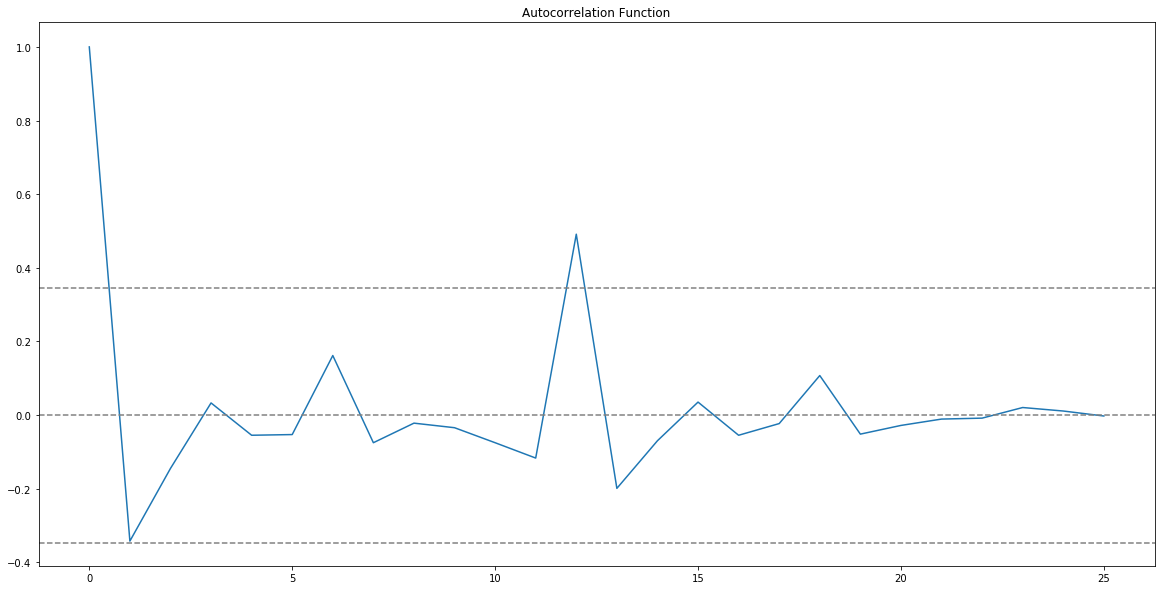

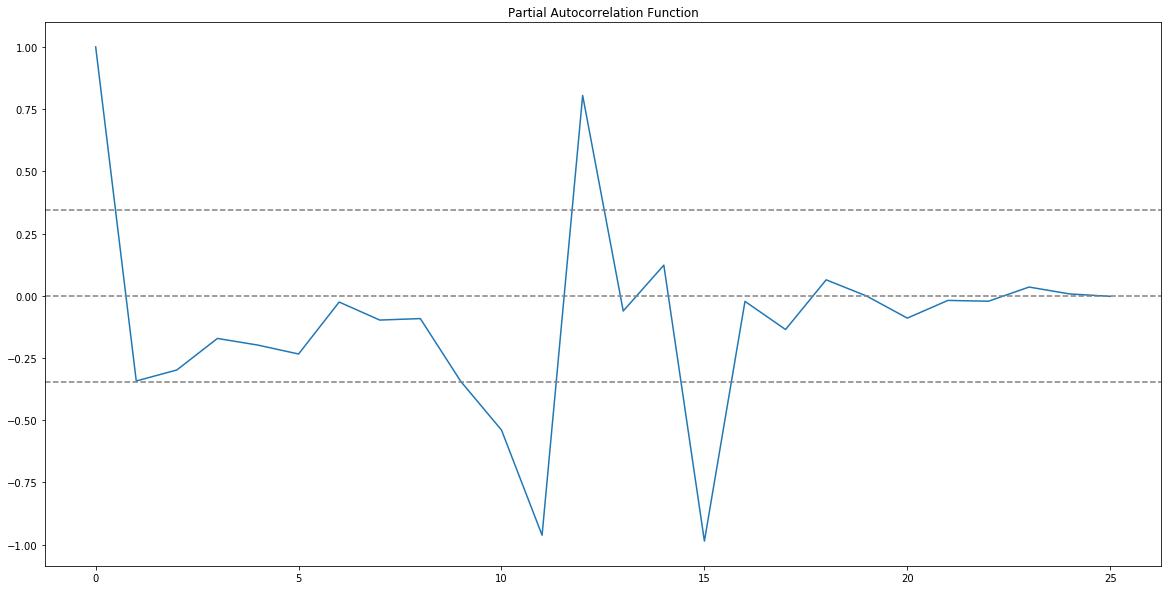

In [65]:
lag_acf = acf(train_log_diff.dropna(),nlags=25)
lag_pacf = pacf(train_log_diff.dropna(),nlags=25,method='ols')
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

In [309]:
#AR 

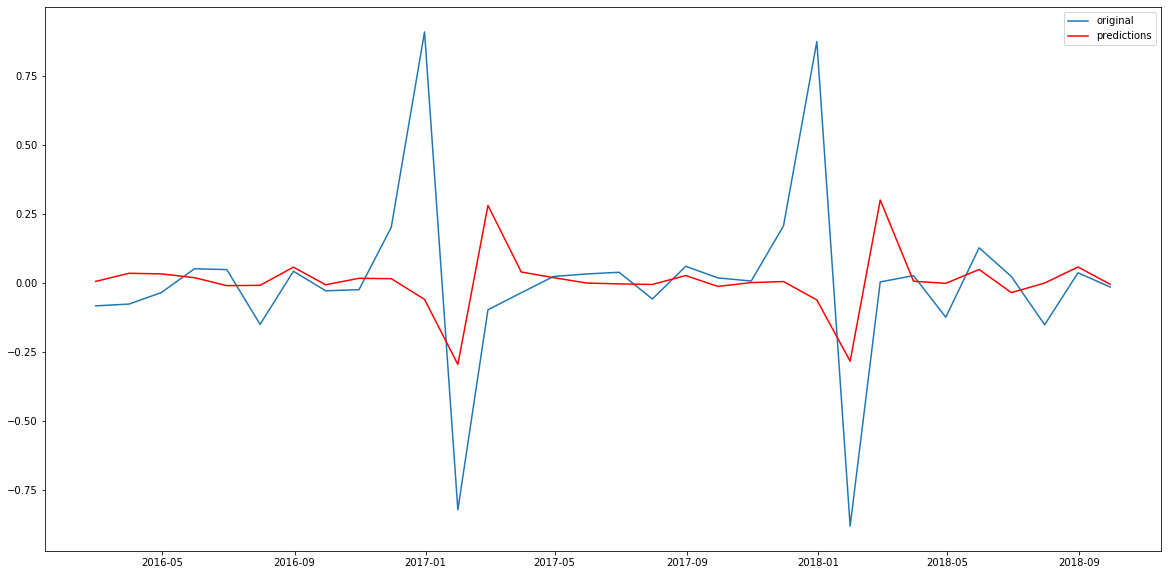

In [53]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Train_log,order=(1,1,0))
results_AR = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(),label='original')
plt.plot(results_AR.fittedvalues,color='red',label='predictions')
plt.legend(loc='best')
plt.show()

(9,)


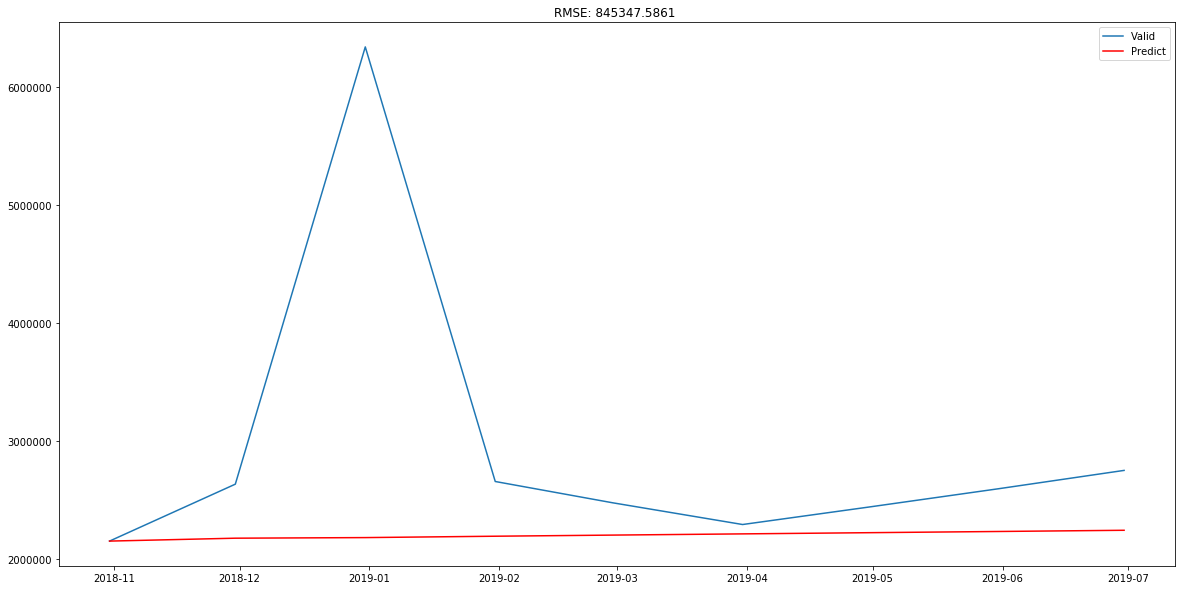

In [66]:
# 2018-10-02':'2019-07-08
# '2018-10-02':'2019-07-08'
AR_predict = results_AR.predict(start='2018-10-02',end='2019-06-08')
print(AR_predict.shape)
AR_predict = AR_predict.cumsum().shift().fillna(0)
AR_predict1 = pd.Series(np.ones(valid.shape[0]) * np.log(valid['Transaction_Count'])[0],index=valid.index)
AR_predict1 = AR_predict1.add(AR_predict,fill_value=0)
AR_predict = np.exp(AR_predict1)
plt.plot(valid['Transaction_Count'],label="Valid")
plt.plot(AR_predict,color='red',label="Predict")
plt.legend(loc="best")
plt.title('RMSE: %.4f '% (np.sqrt(np.dot(AR_predict,valid['Transaction_Count']))/valid.shape[0]))
plt.show()

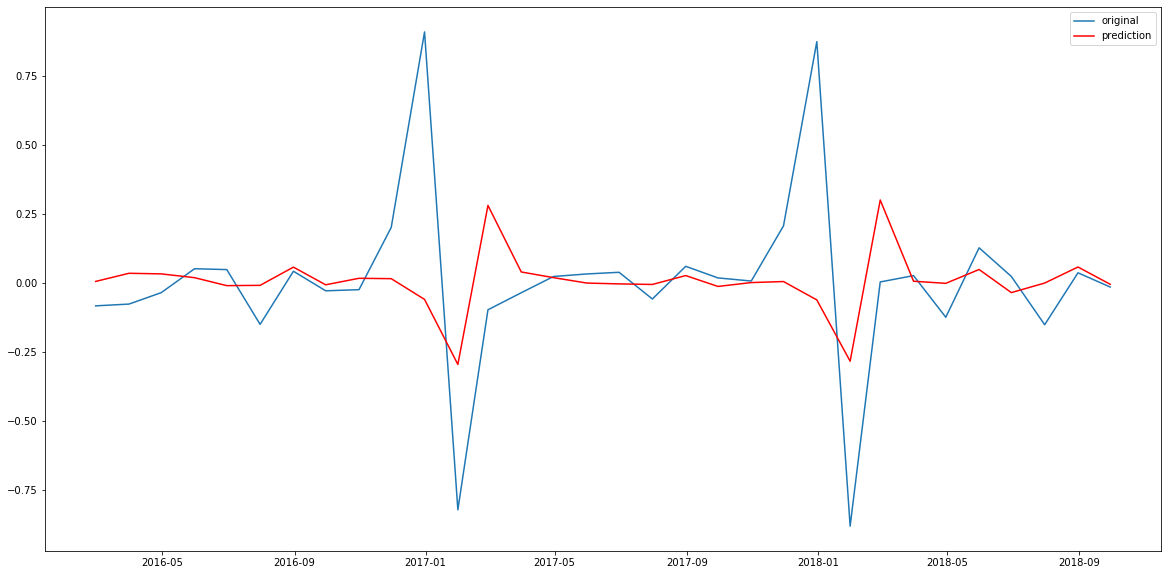

In [52]:
model = ARIMA(Train_log,order=(1,1,0))
results_MA = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(),label='original')
plt.plot(results_MA.fittedvalues,color='red',label='prediction')
plt.legend(loc='best')
plt.show()

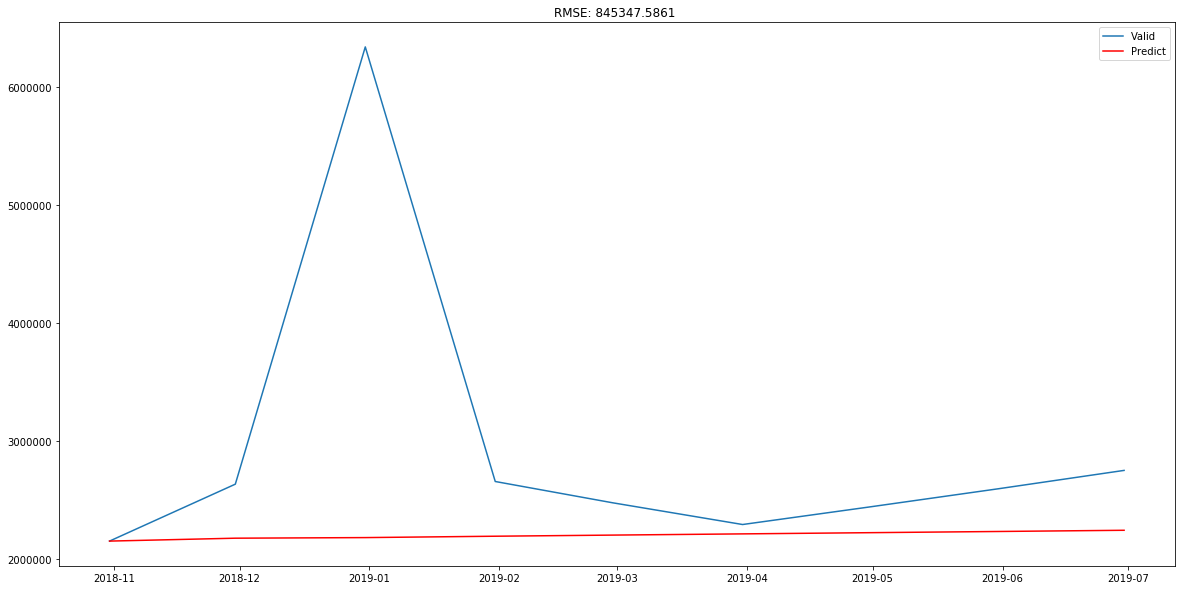

In [67]:
MA_predict = results_MA.predict(start='2018-10-02',end='2019-06-08')
MA_predict = MA_predict.cumsum().shift().fillna(0)
MA_predict1 = pd.Series(np.ones(valid.shape[0]) * np.log(valid['Transaction_Count'])[0],index=valid.index)
MA_predict1 = MA_predict1.add(MA_predict,fill_value=0)
MA_predict = np.exp(MA_predict1)
plt.plot(valid['Transaction_Count'],label="Valid")
plt.plot(MA_predict,color='red',label="Predict")
plt.legend(loc="best")
plt.title('RMSE: %.4f '% (np.sqrt(np.dot(MA_predict,valid['Transaction_Count']))/valid.shape[0]))
plt.show()

### Combined model
## ARIMA

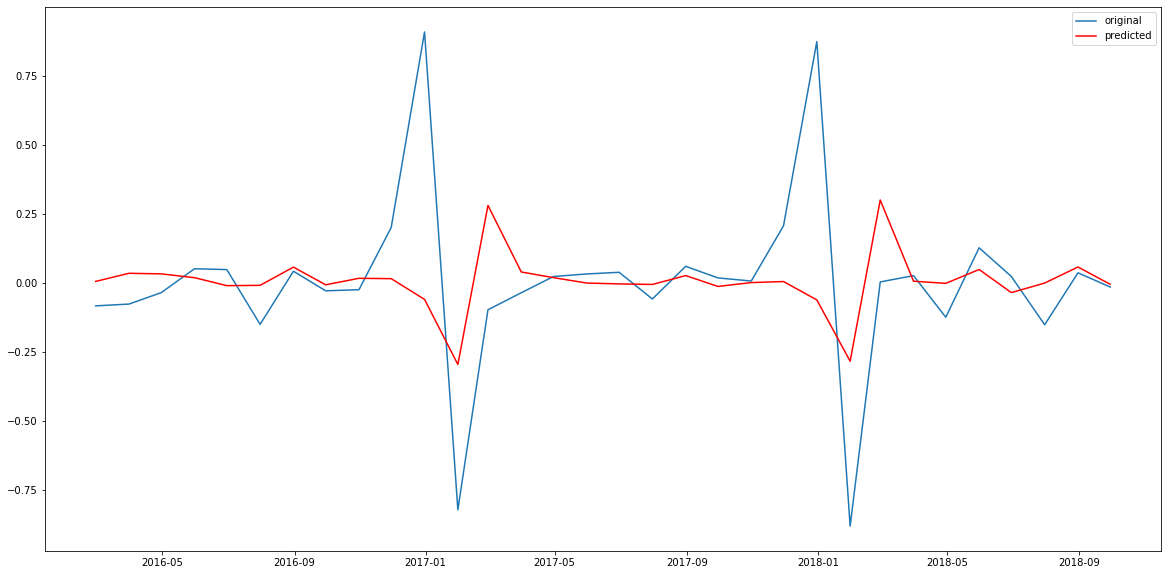

In [69]:
model = ARIMA(Train_log,order=(1,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(train_log_diff.dropna(),label='original')
plt.plot(results_ARIMA.fittedvalues,color='red',label='predicted')
plt.legend(loc='best')
plt.show()

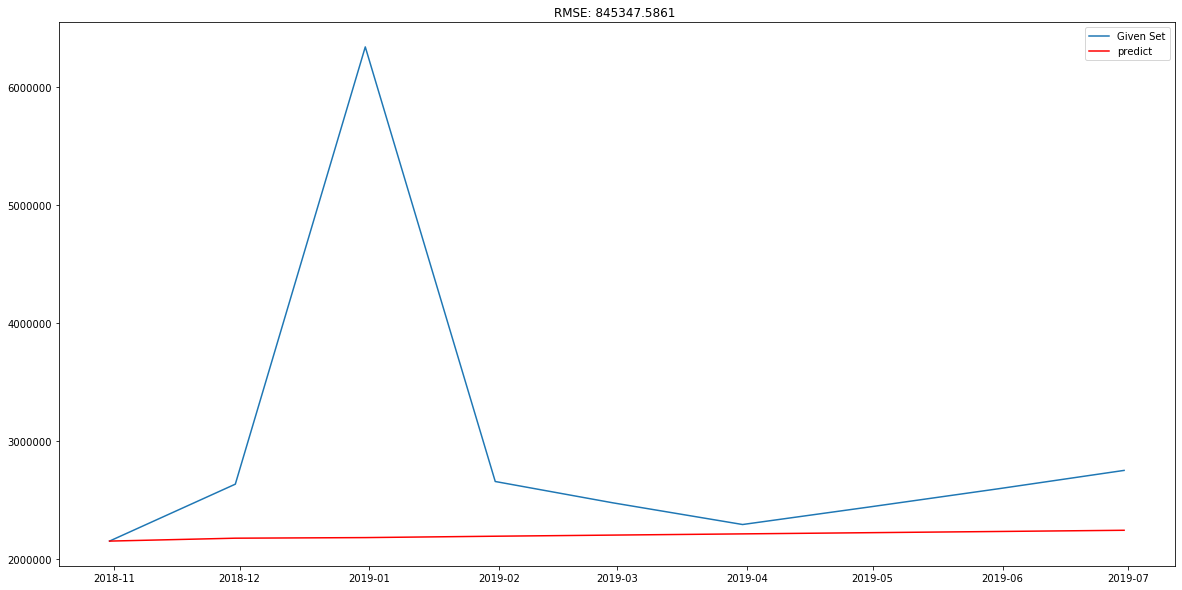

In [71]:
def check_prediction_diff(predict_diff,given_set):
    predict_diff = predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0])*np.log(given_set['Transaction_Count'])[0],index=given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    plt.plot(given_set['Transaction_Count'],label='Given Set')
    plt.plot(predict,color='red',label='predict')
    plt.legend(loc='best')
    plt.title('RMSE: %.4f '%(np.sqrt(np.dot(predict,given_set['Transaction_Count']))/given_set.shape[0]))
    plt.show()
def check_prediction_log(predict_log,given_set):
    predict = np.exp(predict_log)
    plt.plot(given_set['Count'],label='Given set')
    plt.plot(predict,color='red',label='Predict')
    plt.legend(loc='best')
    plt.title('RMSE : %.4f '%(np.sqrt(np.dot(predict,given_set['Count']))/given_set.shape[0]))
    plt.show()
# 2018-10-02':'2019-07-08
ARIMA_predict_diff = results_ARIMA.predict(start='2018-10-02',end='2019-06-08')
check_prediction_diff(ARIMA_predict_diff,valid)

In [73]:
#Seasonality
#SARIMAX
train_1 = train.resample('M').mean()
Train = train_1.ix['2016-01-01':'2018-10-02']
valid = train_1.ix['2018-10-02':'2019-07-08']

C:\Users\ALBIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\ALBIN\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """


C:\Users\ALBIN\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


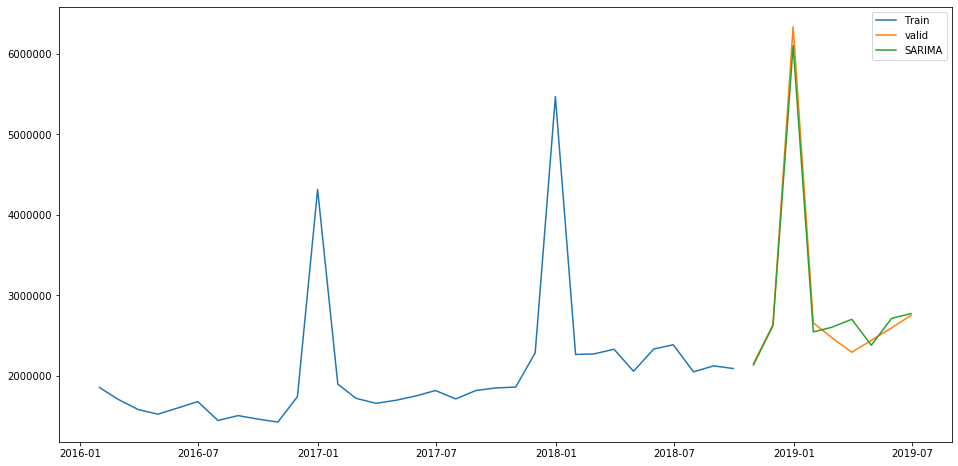

In [77]:
import statsmodels.api as sm
y_hat_avg = valid.copy()
fit1 = sm.tsa.statespace.SARIMAX(Train.Transaction_Count,order=(1,1,1),seasonal_order=(1,1,1,12)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start='2018-10-02',end='2019-06-08')
plt.figure(figsize=(16,8))
plt.plot(Train['Transaction_Count'],label='Train')
plt.plot(valid['Transaction_Count'],label='valid')
plt.plot(y_hat_avg['SARIMA'],label='SARIMA')
plt.legend(loc='best')
plt.show()

In [78]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(valid.Transaction_Count,y_hat_avg.SARIMA))
print(rms)

173061.80204801043
